<a href="https://colab.research.google.com/github/9-coding/Graduation_Project/blob/main/clothing_segmention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-snippets==0.499.0

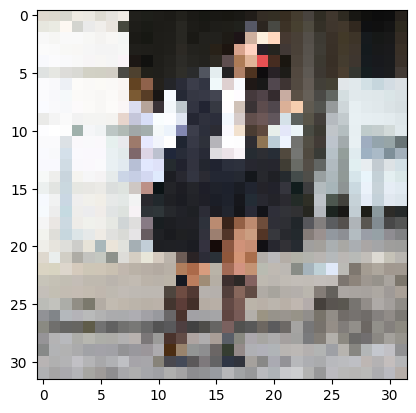

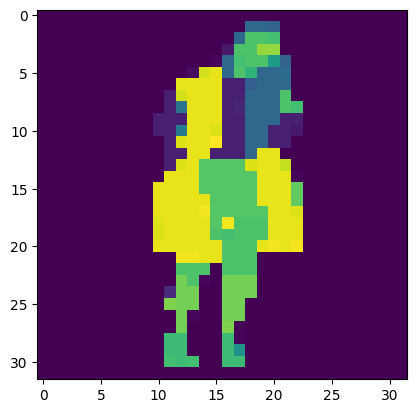

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import torch
import torchvision
import torch.nn.functional as F
from torch import nn
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'


file_path = '/content/drive/MyDrive/Colab Notebooks/graduation_project/archive'

image_paths=[]
mask_paths=[]
train_images=[]
train_labels = []
test_images=[]
test_labels = []
train_dataset=[]



for i in range(100):
    image_paths.append(cv2.imread(file_path + '/jpeg_images/IMAGES/img_' + str(i+1).zfill(4) + '.jpeg'))
    mask_paths.append(cv2.imread(file_path + '/jpeg_masks/MASKS/seg_' + str(i+1).zfill(4) + '.jpeg'))

train_images, test_images, train_masks, test_masks = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

class SegData(Dataset):
    def __init__(self,images,labels):
        self.images=images
        self.labels=labels
    def __len__(self):
        return len(self.images)
    def __getitem__(self, ix):
        image = cv2.imread(file_path + '/jpeg_images/IMAGES/img_' + str(ix+1).zfill(4) + '.jpeg')
        image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (32,32))
        mask = read(file_path + '/jpeg_masks/MASKS/seg_' + str(ix+1).zfill(4) + '.jpeg',1)
        mask = cv2.resize(mask, (32,32))
        mask=cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)
        return image, mask
    def choose(self): return self[randint(len(self))]
    def collate_fn(self, batch):
        ims, masks = list(zip(*batch))
        ims = torch.cat([tfms(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask)[None] for mask in masks]).long().to(device)
        return ims, ce_masks

train_dataset=SegData(train_images,train_masks)
test_dataset=SegData(test_images,test_masks)

image, mask=train_dataset[0]

plt.imshow(image)
plt.figure()
plt.imshow(mask)

In [ ]:
def conv(nin,nout,kernel_size):
  return nn.Sequential(
          nn.Conv2d(nin,nout, kernel_size=kernel_size,padding="same"),
          nn.BatchNorm2d(nout),
          nn.ReLU(inplace=True))

class resconv(nn.Module):
  def __init__(self,in_features,out_features):
    super(resconv,self).__init__()
    self.block=nn.Sequential(
        nn.ReflectionPad2d(1),
        nn.Conv2d(in_features,out_features,3),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),
        nn.ReflectionPad2d(1),
        nn.Conv2d(out_features,out_features,3),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True),

    )
  def forward(self,x):
      return x+self.block(x)

def up_conv(nin,nout):
  return nn.Sequential(
      nn.ConvTranspose2d(nin,nout,kernel_size=2,stride=2),
      nn.InstanceNorm2d(nout),
      nn.ReLU(),
  )

In [ ]:
class ResUnet1(nn.Module):
  def __init__(self):
    super().__init__()
    self.block1=conv(3,64,(7,7))
    self.max_pool=nn.MaxPool2d(2,stride=2)
    self.block2=conv(64,128,(1,1))
    self.block3=conv(128,256,(1,1))
    self.block4=conv(256,512,(1,1))
    self.block2_1=resconv(64,64)
    self.block3_1=resconv(128,128)
    self.block4_1=resconv(256,256)
    self.block_5_1=resconv(512,512)
    self.upconv5=up_conv(512,512)
    self.upconv4=up_conv(512,256)
    self.upconv3=up_conv(256,128)
    self.upconv2=up_conv(128,64)
    self.conv6=conv(512+512,512,kernel_size=(3,3))
    self.conv5=conv(256+256,256,kernel_size=(3,3))
    self.conv4=conv(128+128,128,kernel_size=(3,3))
    self.conv3=conv(64+64,64,kernel_size=(3,3))
    self.last_conv=nn.Conv2d(64,59,kernel_size=(1,1),padding="same")
  def forward(self,x):
    x1=self.block1(x)
    x2=self.max_pool(x1)
    x3=self.block2_1(x2)
    x4=self.block2(x3)
    x5=self.max_pool(x4)
    x6=self.block3_1(x5)
    x7=self.block3(x6)
    x8=self.max_pool(x7)
    x9=self.block4_1(x8)
    x10=self.block4(x9)
    x11=self.max_pool(x10)
    x12=self.block_5_1(x11)
    y12=self.upconv5(x12)
    y_out1=torch.cat([y12,x10],dim=1)
    y_out1=self.conv6(y_out1)
    y11=self.upconv4(y_out1)
    y_out2=torch.cat([y11,x7],dim=1)
    y_out2=self.conv5(y_out2)
    y10=self.upconv3(y_out2)
    y_out3=torch.cat([y10,x4],dim=1)
    y_out3=self.conv4(y_out3)
    y9=self.upconv2(y_out3)
    y_out=torch.cat([y9,x1],dim=1)
    y_out=self.conv3(y_out)
    out=self.last_conv(y_out)
    return out

In [ ]:
model=ResUnet1()
model=model.to(device)

In [ ]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.argmax(preds,1) == targets).float().mean()
    return ce_loss, acc


In [ ]:
criterion=UnetLoss
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)
scheduler=torch.optim.lr_scheduler.StepLR(optimizer,gamma=0.5,step_size=15)


In [ ]:
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=8,shuffle=True,collate_fn=train_dataset.collate_fn)
test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=8,shuffle=False,collate_fn=test_dataset.collate_fn)

In [ ]:
image,mask=next(iter(train_dataloader))
image.shape

torch.Size([8, 3, 32, 32])

In [ ]:
def train_batch(model, data, optimizer, criterion):
    ims, ce_masks = data
    ims=ims
    ce_masks=ce_masks
    model.train()
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()
@torch.no_grad()
def valid_batch(model, data, criterion):
    model.eval()
    ims, ce_masks = data
    ims=ims
    ce_masks=ce_masks
    _masks = model(ims)
    loss, acc = criterion(_masks, ce_masks)
    return loss.item(), acc.item()